<a href="https://colab.research.google.com/github/shobhitsundriyal/startml/blob/master/03_Amazon_Fine_Food_Reviews_Analysis_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/gdrive')

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import seaborn as sb

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('gdrive/My Drive/AFR/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 2543.87it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
sample_points = preprocessed_reviews
labels = final['Score']

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(
    sample_points, labels, test_size=0.3, random_state=0)

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
train_list_of_sentance=[]
for sentance in X_train:
    train_list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    train_w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(train_w2v_model.wv.most_similar('great'))
    print('='*50)
    print(train_w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        train_w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(train_w2v_model.wv.most_similar('great'))
        print(train_w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('alternative', 0.9994263052940369), ('care', 0.9991533756256104), ('greasy', 0.9990972280502319), ('texture', 0.9990515112876892), ('fried', 0.9990097284317017), ('probably', 0.9990062713623047), ('amazing', 0.9989997148513794), ('popchips', 0.9989818334579468), ('crispy', 0.9989776015281677), ('although', 0.9989709258079529)]
[('excellent', 0.9995973110198975), ('finally', 0.9995796084403992), ('house', 0.999567985534668), ('wanted', 0.9995512366294861), ('wonderful', 0.9995459914207458), ('part', 0.9995392560958862), ('cooking', 0.9995348453521729), ('yummy', 0.9995347857475281), ('ready', 0.9995336532592773), ('come', 0.9995273947715759)]


In [0]:
train_w2v_words = list(train_w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(train_w2v_words))
print("sample words ", train_w2v_words[0:50])

number of words that occured minimum 5 times  3125
sample words  ['lb', 'dog', 'never', 'refused', 'eat', 'newman', 'organic', 'glad', 'pet', 'food', 'made', 'without', 'junk', 'feed', 'quick', 'convenient', 'way', 'drink', 'green', 'tea', 'add', 'lemon', 'juice', 'stevia', 'steal', 'make', 'lot', 'gingerbread', 'cookies', 'holidays', 'large', 'ones', 'long', 'bag', 'bags', 'look', 'like', 'bought', 'store', 'best', 'cheap', 'weight', 'watcher', 'months', 'lost', 'pounds', 'important', 'part', 'watchers', 'find']


In [0]:
#For X_test
i=0
test_list_of_sentance=[]
for sentance in X_test:
    test_list_of_sentance.append(sentance.split())

In [0]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    test_w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(test_w2v_model.wv.most_similar('great'))
    print('='*50)
    print(test_w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        test_w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(test_w2v_model.wv.most_similar('great'))
        print(test_w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('easy', 0.9998840689659119), ('get', 0.9998803734779358), ('little', 0.9998750686645508), ('best', 0.9998748898506165), ('also', 0.9998738169670105), ('use', 0.9998735189437866), ('right', 0.9998729228973389), ('without', 0.9998709559440613), ('make', 0.9998688697814941), ('found', 0.9998682141304016)]
[('pass', 0.9946870803833008), ('weak', 0.9946801662445068), ('cakes', 0.9946449398994446), ('raw', 0.9945597648620605), ('leave', 0.9945183396339417), ('jalapeno', 0.9944760203361511), ('cheddar', 0.9944660067558289), ('means', 0.9944522380828857), ('unique', 0.9944308996200562), ('molasses', 0.9944264888763428)]


In [0]:
test_w2v_words = list(test_w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(test_w2v_words))
print("sample words ", test_w2v_words[0:50])

number of words that occured minimum 5 times  1833
sample words  ['ordered', 'friend', 'south', 'christmas', 'want', 'try', 'italian', 'chocolates', 'lol', 'item', 'arrived', 'earlier', 'expected', 'well', 'packed', 'mouth', 'totally', 'loves', 'three', 'different', 'taste', 'flavors', 'give', 'yummy', 'feeding', 'wellness', 'grain', 'free', 'couple', 'years', 'great', 'results', 'cats', 'believe', 'cost', 'top', 'quality', 'food', 'worth', 'healthy', 'happy', 'reduced', 'vet', 'still', 'excited', 'see', 'felidae', 'formula', 'larger', 'sized']


In [0]:
print(len(train_w2v_words), len(test_w2v_words))

3125 1833


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(train_list_of_sentance): # for each review/sentence
    train_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in train_w2v_words:
            vec = train_w2v_model.wv[word]
            train_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        train_vec /= cnt_words
    train_vectors.append(train_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

100%|██████████| 3490/3490 [00:02<00:00, 1353.63it/s]

3490
50


In [0]:
test_vectors = []; 
for sent in tqdm(test_list_of_sentance): 
    test_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in test_w2v_words:
            vec = test_w2v_model.wv[word]
            test_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        test_vec /= cnt_words
    test_vectors.append(test_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

100%|██████████| 1496/1496 [00:00<00:00, 1770.93it/s]

1496
50


In [0]:
X_train = train_vectors
X_test = test_vectors

#### [4.4.1.2] TFIDF weighted W2v

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(
    sample_points, labels, test_size=0.3)
print(len(X_train), len(X_test), len(Y_train), len(Y_test))

3490 1496 3490 1496


In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
train_tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(train_list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in train_w2v_words and word in tfidf_feat:
            vec = train_w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 3490/3490 [00:18<00:00, 191.93it/s]


In [0]:
#For test part
tmodel = TfidfVectorizer()
test_tf_idf_matrix = tmodel.fit_transform(X_test)
dictionary = dict(zip(tmodel.get_feature_names(), list(tmodel.idf_)))

In [0]:
tfidf_feat = tmodel.get_feature_names()

test_tfidf_sent_vectors = []; 
row=0;
for sent in tqdm(test_list_of_sentance): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in test_w2v_words and word in tfidf_feat:
            vec = test_w2v_model.wv[word]             
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 1496/1496 [00:04<00:00, 318.05it/s]


In [0]:
X_train = train_tfidf_sent_vectors
X_test = test_tfidf_sent_vectors

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [0]:
final[final['Score'] == 1]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...
2941,3203,B000084DVR,A3DKGXWUEP1AI2,"Glenna E. Bauer ""Puppy Mum""",3,3,1,1163030400,Premium Quality Dog Food!!!,We have been using this food for about 6 month...
1071,1161,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1,1,1140739200,Cats love it!,I have nine cats and they are crazy about thes...
2187,2380,B0000CGFV4,A3LSUKN4IFS6VD,Internet Diva,0,0,1,1312416000,"Nice, Big Pieces & Big Almond Flavor",These were shipped out the day after I ordered...
4695,5097,B0000D94SZ,A2R91PG1XPNO0B,"Kotton Kandee ""not so secretshopper""",4,4,1,1184198400,"A Summer Treat Fat Free, Guilt Free",This mix is probably not something you would w...
2806,3053,B0000E65W9,A1GJ37VZOZ6S1W,"S. Jettlund ""mamaknows2much""",0,0,1,1308700800,A Staple in my house,I use these to keep my finicky toddler's prote...


(array([ 808.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4178.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

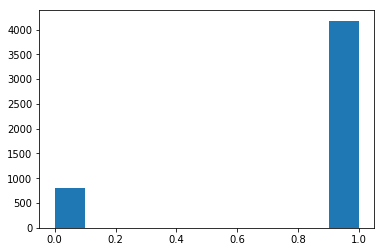

In [0]:
import matplotlib.pyplot as plt
plt.hist(final['Score'])

In [0]:
final['CleanedText'] = preprocessed_reviews
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...,glad cocker standard poodle puppy loves stuff ...
2941,3203,B000084DVR,A3DKGXWUEP1AI2,"Glenna E. Bauer ""Puppy Mum""",3,3,1,1163030400,Premium Quality Dog Food!!!,We have been using this food for about 6 month...,using food months find excellent fact two dogs...
1071,1161,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1,1,1140739200,Cats love it!,I have nine cats and they are crazy about thes...,nine cats crazy kibbles last thing want cat fo...
2187,2380,B0000CGFV4,A3LSUKN4IFS6VD,Internet Diva,0,0,1,1312416000,"Nice, Big Pieces & Big Almond Flavor",These were shipped out the day after I ordered...,shipped day ordered arrived within days live o...
4695,5097,B0000D94SZ,A2R91PG1XPNO0B,"Kotton Kandee ""not so secretshopper""",4,4,1,1184198400,"A Summer Treat Fat Free, Guilt Free",This mix is probably not something you would w...,mix probably not something would want use ever...
2068,2256,B0000DC5IY,AGYZZ3QXV9S8,"Dr. Glenn B. Gero ""NJnaturaldoc""",3,4,0,1289865600,Don't buy this product unless you are looking ...,The description of this product is disceptive....,description product disceptive product represe...


In [0]:
# Please write all the code with proper documentation
positive_points = final[final['Score'] == 1].sample(
    n=900, random_state=0)
negative_points = final[final['Score'] == 0].sample(
    n=808, random_state=0)
total_points = pd.concat([positive_points, negative_points])

# Sorting based on time
total_points['Time'] = pd.to_datetime(
    total_points['Time'], origin='unix', unit='s')
total_points = total_points.sort_values('Time')
sample_points = total_points['CleanedText']
labels = total_points['Score']

In [0]:
# Splitting into train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    sample_points, labels, test_size=0.30, random_state=0)

count_vect = CountVectorizer(ngram_range=(1, 1))
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

In [0]:
neighbors = list(range(20, 80, 4))
cv_score = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())

_____________________________________________________________________________________________________
Optimal number of neighbors:  24
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.322 0.31  0.32  0.33  0.335 0.346 0.357 0.353 0.357 0.364 0.364 0.373
 0.376 0.377 0.378]
_____________________________________________________________________________________________________


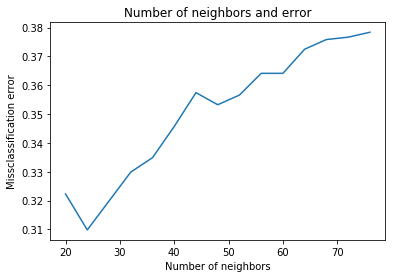

In [0]:
#Missclassification Error

MSE = [1 - x for x in cv_score]
optimal_k = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
#Accuracy Score
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k)
optimal_model.fit(X_train, Y_train)
prediction = optimal_model.predict(X_test)

training_accuracy = optimal_model.score(X_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.7238493723849372
Train Error:  0.2761506276150628
Test Accuracy:  0.6939571150097466
Test Error:  0.30604288499025345
_____________________________________________________________________________________________________


In [0]:
#classification report

from sklearn.metrics import classification_report
print("_" * 101)
print("Classification Report: \n")
print(classification_report(Y_test, prediction))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       254
           1       0.68      0.74      0.71       259

    accuracy                           0.69       513
   macro avg       0.70      0.69      0.69       513
weighted avg       0.70      0.69      0.69       513

_____________________________________________________________________________________________________


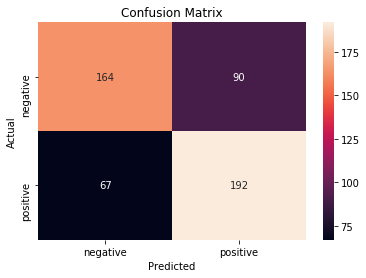

_____________________________________________________________________________________________________


In [0]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(Y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation
# Splitting into train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    sample_points, labels, test_size=0.30)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1195,) (513,) (1195,) (513,)


In [0]:
# Initializing tfidf vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))

# Fitting for tfidf vectorization
X_train = tfidf_vect.fit_transform(X_train)
X_test = tfidf_vect.transform(X_test)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1195, 6488) (513, 6488) (1195,) (513,)


In [0]:
neighbors = list(range(20, 80, 4))
cv_score = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())

_____________________________________________________________________________________________________
Optimal number of neighbors:  72
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.268 0.269 0.268 0.263 0.254 0.256 0.262 0.259 0.264 0.254 0.254 0.253
 0.247 0.242 0.249]
_____________________________________________________________________________________________________


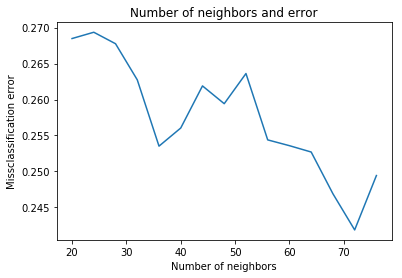

In [0]:
#Miscalssification Error
MSE = [1 - x for x in cv_score]
optimal_k = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)

plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
#Accuracy Score
optimal_model = KNeighborsClassifier(
    n_neighbors=optimal_k, algorithm='brute')#brute
optimal_model.fit(X_train, Y_train)
prediction = optimal_model.predict(X_test)

training_accuracy = optimal_model.score(X_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.7723849372384938
Train Error:  0.22761506276150623
Test Accuracy:  0.7446393762183235
Test Error:  0.25536062378167645
_____________________________________________________________________________________________________


In [0]:
#Classification Report
print("_" * 101)
print("Classification Report: \n")
print(classification_report(Y_test, prediction))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

           0       0.84      0.58      0.69       247
           1       0.70      0.90      0.78       266

    accuracy                           0.74       513
   macro avg       0.77      0.74      0.74       513
weighted avg       0.77      0.74      0.74       513

_____________________________________________________________________________________________________


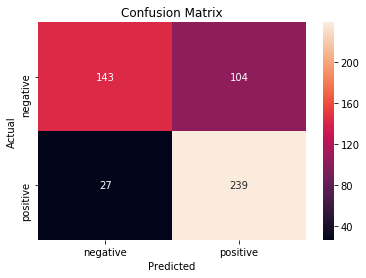

In [0]:
#Confusion Matrix
conf_matrix = confusion_matrix(Y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [0]:
sent_vectors

In [0]:
# Please write all the code with proper documentation
neighbors = list(range(20, 50, 2))
cv_score = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())

_____________________________________________________________________________________________________
Optimal number of neighbors:  28
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.17  0.17  0.17  0.169 0.169 0.169 0.169 0.169 0.169 0.169 0.169 0.169
 0.169 0.169 0.169]
_____________________________________________________________________________________________________


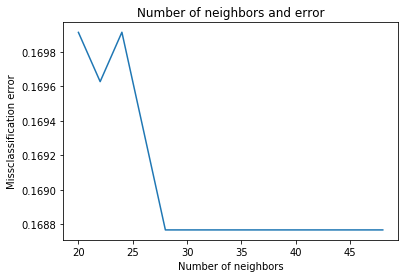

In [0]:
#Misclassification Error

MSE = [1 - x for x in cv_score]
optimal_k = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)

plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()


In [0]:
#Accuracy Score

optimal_model = KNeighborsClassifier(
    n_neighbors=optimal_k, algorithm='kd_tree')
optimal_model.fit(X_train, Y_train)
prediction = optimal_model.predict(X_test)

training_accuracy = optimal_model.score(X_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8312320916905445
Train Error:  0.16876790830945554
Test Accuracy:  0.8536096256684492
Test Error:  0.14639037433155078
_____________________________________________________________________________________________________


In [0]:
#Classification Report

print("_" * 101)
print("Classification Report: \n")
print(classification_report(Y_test, prediction))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       219
           1       0.85      1.00      0.92      1277

    accuracy                           0.85      1496
   macro avg       0.43      0.50      0.46      1496
weighted avg       0.73      0.85      0.79      1496

_____________________________________________________________________________________________________


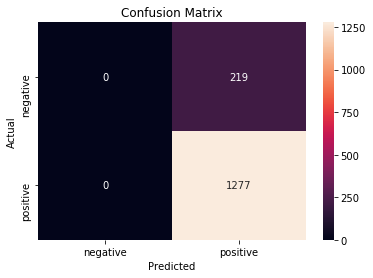

_____________________________________________________________________________________________________


In [0]:
#Confusion Matrix

conf_matrix = confusion_matrix(Y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation
neighbors = list(range(1, 50, 2))
cv_score = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())

_____________________________________________________________________________________________________
Optimal number of neighbors:  19
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.269 0.211 0.189 0.177 0.169 0.166 0.165 0.165 0.163 0.162 0.162 0.162
 0.162 0.162 0.162 0.162 0.162 0.162 0.162 0.162 0.162 0.162 0.162 0.162
 0.162]
_____________________________________________________________________________________________________


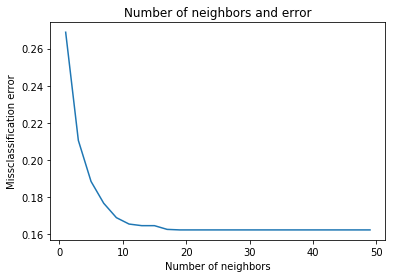

In [0]:
#Misclassification Error

MSE = [1 - x for x in cv_score]
optimal_k = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
#for xy in zip(neighbors, np.round(MSE, 3)):
#    plt.annotate("%s %s" %xy, xy=xy, textcoords='data')
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
#Accuracy Score

optimal_model = KNeighborsClassifier(
    n_neighbors=optimal_k, algorithm='kd_tree')
optimal_model.fit(X_train, Y_train)
prediction = optimal_model.predict(X_test)

training_accuracy = optimal_model.score(X_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8375358166189112
Train Error:  0.1624641833810888
Test Accuracy:  0.838903743315508
Test Error:  0.161096256684492
_____________________________________________________________________________________________________


In [0]:
#Classification Report

print("_" * 101)
print("Classification Report: \n")
print(classification_report(Y_test, prediction))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       241
           1       0.84      1.00      0.91      1255

    accuracy                           0.84      1496
   macro avg       0.42      0.50      0.46      1496
weighted avg       0.70      0.84      0.77      1496

_____________________________________________________________________________________________________


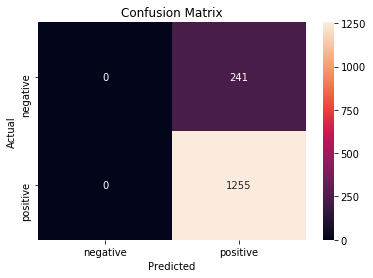

_____________________________________________________________________________________________________


In [0]:
#Confusion Matrix

conf_matrix = confusion_matrix(Y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [0]:
# Please write all the code with proper documentation
neighbors = list(range(20, 80, 4))
cv_score = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())

_____________________________________________________________________________________________________
Optimal number of neighbors:  24
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.322 0.31  0.32  0.33  0.335 0.346 0.357 0.353 0.357 0.364 0.364 0.373
 0.376 0.377 0.378]
_____________________________________________________________________________________________________


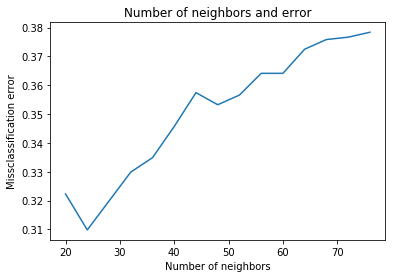

In [0]:
#Misclassification Error
MSE = [1 - x for x in cv_score]
optimal_k = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
#for xy in zip(neighbors, np.round(MSE, 3)):
#    plt.annotate("%s %s" %xy, xy=xy, textcoords='data')
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
#Accuracy Score

optimal_model = KNeighborsClassifier(
    n_neighbors=optimal_k, algorithm='kd_tree')#kd tree
optimal_model.fit(X_train, Y_train)
prediction = optimal_model.predict(X_test)

training_accuracy = optimal_model.score(X_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.7238493723849372
Train Error:  0.2761506276150628
Test Accuracy:  0.6939571150097466
Test Error:  0.30604288499025345
_____________________________________________________________________________________________________


In [0]:
#Classification Report
print("Classification Report: \n")
print(classification_report(Y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       254
           1       0.68      0.74      0.71       259

    accuracy                           0.69       513
   macro avg       0.70      0.69      0.69       513
weighted avg       0.70      0.69      0.69       513



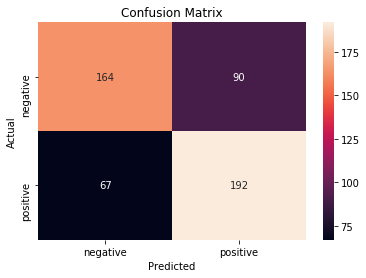

_____________________________________________________________________________________________________


In [0]:
#Confusion Matrix
conf_matrix = confusion_matrix(Y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [0]:
# Please write all the code with proper documentation
neighbors = list(range(20, 80, 4))
cv_score = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())

_____________________________________________________________________________________________________
Optimal number of neighbors:  72
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.268 0.269 0.268 0.263 0.254 0.256 0.262 0.259 0.264 0.254 0.254 0.253
 0.247 0.242 0.249]
_____________________________________________________________________________________________________


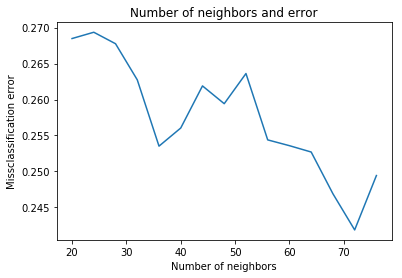

In [0]:
#Misclassification Error
MSE = [1 - x for x in cv_score]
optimal_k = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
#for xy in zip(neighbors, np.round(MSE, 3)):
#    plt.annotate("%s %s" %xy, xy=xy, textcoords='data')
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
#Accuracy Score
optimal_model = KNeighborsClassifier(
    n_neighbors=optimal_k, algorithm='kd_tree')
optimal_model.fit(X_train, Y_train)
prediction = optimal_model.predict(X_test)

training_accuracy = optimal_model.score(X_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.7723849372384938
Train Error:  0.22761506276150623
Test Accuracy:  0.7446393762183235
Test Error:  0.25536062378167645
_____________________________________________________________________________________________________


In [0]:
#Classificatoin Report
print("_" * 101)
print("Classification Report: \n")
print(classification_report(Y_test, prediction))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

           0       0.84      0.58      0.69       247
           1       0.70      0.90      0.78       266

    accuracy                           0.74       513
   macro avg       0.77      0.74      0.74       513
weighted avg       0.77      0.74      0.74       513

_____________________________________________________________________________________________________


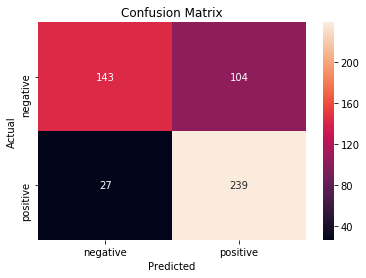

_____________________________________________________________________________________________________


In [0]:
#Confusion Matrix
conf_matrix = confusion_matrix(Y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation
neighbors = list(range(20, 50, 4))
cv_score = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())

_____________________________________________________________________________________________________
Optimal number of neighbors:  28
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.17  0.17  0.169 0.169 0.169 0.169 0.169 0.169]
_____________________________________________________________________________________________________


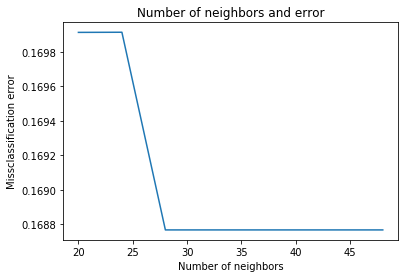

In [0]:
#Misclassification Error

MSE = [1 - x for x in cv_score]
optimal_k = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
#for xy in zip(neighbors, np.round(MSE, 3)):
#    plt.annotate("%s %s" %xy, xy=xy, textcoords='data')
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
#Accuracy Score

optimal_model = KNeighborsClassifier(
    n_neighbors=optimal_k, algorithm='kd_tree')
optimal_model.fit(X_train, Y_train)
prediction = optimal_model.predict(X_test)

training_accuracy = optimal_model.score(X_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8312320916905445
Train Error:  0.16876790830945554
Test Accuracy:  0.8536096256684492
Test Error:  0.14639037433155078
_____________________________________________________________________________________________________


In [0]:
#Classification Report

print("_" * 101)
print("Classification Report: \n")
print(classification_report(Y_test, prediction))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       219
           1       0.85      1.00      0.92      1277

    accuracy                           0.85      1496
   macro avg       0.43      0.50      0.46      1496
weighted avg       0.73      0.85      0.79      1496

_____________________________________________________________________________________________________


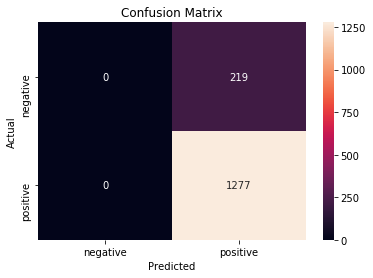

_____________________________________________________________________________________________________


In [0]:
#Confusion Matrix

conf_matrix = confusion_matrix(Y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation
neighbors = list(range(1, 50, 2))
cv_score = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())

_____________________________________________________________________________________________________
Optimal number of neighbors:  19
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.269 0.211 0.189 0.177 0.169 0.166 0.165 0.165 0.163 0.162 0.162 0.162
 0.162 0.162 0.162 0.162 0.162 0.162 0.162 0.162 0.162 0.162 0.162 0.162
 0.162]
_____________________________________________________________________________________________________


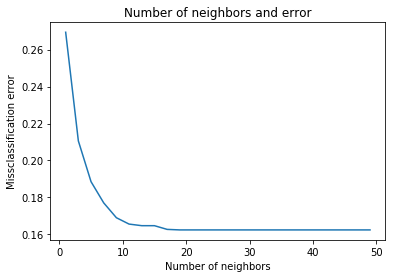

In [0]:
#Misclassification Error

MSE = [1 - x for x in cv_score]
optimal_k = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
#for xy in zip(neighbors, np.round(MSE, 3)):
#    plt.annotate("%s %s" %xy, xy=xy, textcoords='data')
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()


In [0]:
#Accuracy Score

optimal_model = KNeighborsClassifier(
    n_neighbors=optimal_k, algorithm='kd_tree')
optimal_model.fit(X_train, Y_train)
prediction = optimal_model.predict(X_test)

training_accuracy = optimal_model.score(X_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy

print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8375358166189112
Train Error:  0.1624641833810888
Test Accuracy:  0.838903743315508
Test Error:  0.161096256684492
_____________________________________________________________________________________________________


In [0]:
#Classification Report

print("_" * 101)
print("Classification Report: \n")
print(classification_report(Y_test, prediction))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       241
           1       0.84      1.00      0.91      1255

    accuracy                           0.84      1496
   macro avg       0.42      0.50      0.46      1496
weighted avg       0.70      0.84      0.77      1496

_____________________________________________________________________________________________________


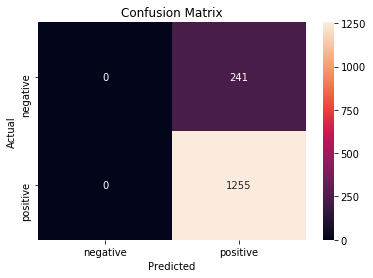

In [0]:
#Confusion Matrix

conf_matrix = confusion_matrix(Y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# [6] Conclusions

In [0]:
!pip install Ptable

  Created wheel for Ptable: filename=PTable-0.9.2-cp36-none-any.whl size=22907 sha256=9d99025d8bbce9bab99be81a7fbeb998221322d3d17b902125ec3824db24a057
  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built Ptable


In [0]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable

bf = PrettyTable()
kd = PrettyTable()

bf.field_names = ['Featurization', "Train Accuracy", "Train Error", "Test Accuracy", "Test Error"]
kd.field_names = ['Featurization', "Train Accuracy", "Train Error", "Test Accuracy", "Test Error"]

bf.add_row(['BoW', 72.38, 27.61, 69.39, 30.60])
bf.add_row(['TF-idf', 77.23, 22.76, 74.46, 25.53])
bf.add_row(['Avg-w2v', 83.12, 16.87, 85.36, 14.63])
bf.add_row(['TF-idf w2v', 83.75, 16.24, 83.89, 16.10])

kd.add_row(['BoW', 72.83, 27.61, 69.39, 30.60])
kd.add_row(['TF-idf', 77.23, 22.76, 74.46, 25.53])
kd.add_row(['Avg-w2v', 83.12, 16.87, 85.36, 14.63])
kd.add_row(['TF-idf w2v',83.75, 16.24, 83.89, 16.10])

print('Accuracy Report in %:')
print ('Knn Brute Force:\n', bf)
print ('Knn Kd tree:\n', kd)

Accuracy Report in %:
Knn Brute Force:
 +---------------+----------------+-------------+---------------+------------+
| Featurization | Train Accuracy | Train Error | Test Accuracy | Test Error |
+---------------+----------------+-------------+---------------+------------+
|      BoW      |     72.38      |    27.61    |     69.39     |    30.6    |
|     TF-idf    |     77.23      |    22.76    |     74.46     |   25.53    |
|    Avg-w2v    |     83.12      |    16.87    |     85.36     |   14.63    |
|   TF-idf w2v  |     83.75      |    16.24    |     83.89     |    16.1    |
+---------------+----------------+-------------+---------------+------------+
Knn Kd tree:
 +---------------+----------------+-------------+---------------+------------+
| Featurization | Train Accuracy | Train Error | Test Accuracy | Test Error |
+---------------+----------------+-------------+---------------+------------+
|      BoW      |     72.83      |    27.61    |     69.39     |    30.6    |
|     TF-i

##Conclusions
1.  All accuracy are same either using brute force or kd tree method.
2. For word2vec either avgw2v or tfidgw2v the model is skewed toward positive class, <br>   so it can be said that this model is not suitable for Word2vec.
3.BoW has accuracy of around 71%, and Tfidf with slightly better accuracy of around 75% 

##Reference
https://www.kaggle.com/jitendras/knn-amazon-fine-food-reviews-data-set#TFIDF-Word2Vec